#Introduction

After extracting policies from the urban planning documents, we want to categorize each policy under a broader topic. The process used is Latent Dirichlet Allocation (LDA), a probabilistic topic modeling technique to uncover hidden topics within documents. To analyze and categorize the policies efficiently, organizing each output from the policy extraction step into a tabular format, such as .csv, is vital.

#Process

The categorization process consists of the following steps:
1. Placing the policies into a spreadsheet (csv, xlsx, etc)
2. Preprocessing the policies to ensure the model picks up important keywords
3. Feeding the preprocessed spreadsheet in the algorithm
4. Fine-tune the number of topics
5. Hand-labeling topics or LLM-labeled topics
6. Analysis of the results (what topics are the most important/most occurring)
7. Checking for significant results, may have to emphasize granularity

Below is an example using the Atascadero general plan:

#Example: Atascedero General Plan

## These first few steps revolve around preprocessing and text cleaning prior to the LDA model.

First we will import all the neccesary libraries to carry out the task, if the following libraries are not downloaded first you can do so by running the code chunk below.

## Downloading and importing necessary libraries

In [ ]:
!pip install pandas
!pip install sklearn
!pip install fpdf
!pip install matplotlib
!pip install collections
!pip install numpy

ERROR: Could not find a version that satisfies the requirement re (from versions: none)
ERROR: No matching distribution found for re
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
  Preparing metadata (setup.py) ... done
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40704 sha256=8507ea8aedc784c8205a59a7822a7c9870c020c8f1ffcbd668c6815c84fe4fce
  Stored in directory: /root/.cache/pip/wheels/65/4f/66/bbda9866da446a72e206d6484cd97381cbc7859a7068541c36
Successfully built fpdf
ERROR: Could not find a version that satisfies the requireme

In [ ]:
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from fpdf import FPDF
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from collections import defaultdict

## Loading in and preprocessing the data

From the policy extraction step we should have all the policies stored onto some sort of spreadsheet, in this case we will be using a csv with all the policies from atascedero.

In [ ]:
def load_csv(csv_path, text_columns):
    df = pd.read_csv(csv_path)
    df["combined_text"] = df[text_columns].fillna("").agg(" ".join, axis=1)
    return df["combined_text"].astype(str).tolist()

Above is a quick function used to read in our file, below we will go over how to use this function to read in our csv file.

In [ ]:
# Atascedero GP policy spreadsheet link: https://drive.google.com/file/d/12XHO1762_8Ir44DDT_Lib0Grnhb-14DI/view?usp=sharing
file_id = '12XHO1762_8Ir44DDT_Lib0Grnhb-14DI'
csv_path = f'https://drive.google.com/uc?id={file_id}'

text_columns = ["Goal", "Policy", "Program"] # Update according to your CSV structure (Goal, Policy, Program are the names of each column in our CSV file)
documents = load_csv(csv_path, text_columns)

We change our text columns depending on how the csv is structured, in this example our columns have the following names of Goal, Policy, and Program. Note that the column names are case sensitive so if your column is named goal make sure to put in goal rather than Goal. **In this specific document, the programs and policies were nested within the goals, however this may not always be the case (it is important to assess policy structure before this step).**

Next we will begin to preprocess the uploaded csv file to prepare it for the LDA model and ensure we are capturing important keywords. Below is a function created to carry out this task. We can edit this with extra regular expressions to create a greater emphasis on preprocessing depending on the type of document given.


In [ ]:
def preprocess_text(text):
    text = re.sub(r'^Goal [A-Z]+/[A-Z]+-\d+:\s*', '', text)
    text = re.sub(r'^Policy [A-Z]+/[A-Z]+-\d+:\s*', '', text)
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text

In [ ]:
processed_docs = [preprocess_text(doc) for doc in documents]  # Cleans each row using the preprocess_text function in previous chunk

## From this point onward, all the related code involves the LDA model with information about how to set up the model to analyzing it efficiently.

Finally we begin to run our model on the preprocessed text and will also fine-tune the number of topics for the Atascedero document.

In [ ]:
vectorizer = TfidfVectorizer(stop_words='english') # Removes common words like the, if, etc to make sure our analysis is more concise; reduces noise
dtm = vectorizer.fit_transform(processed_docs)  # Each policy/program/goal is treated as a separate "document"
num_topics = 16  # Adjust number of topics
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(dtm)

The main thing to note here is the number of topics which we have set to 16 in this specific example. This will vary depending on the type of document we have, so how do we **pick the most optimal number of topics**?
* reduce the number of topics if keywords start to repeat
* increase the number of topics if the topics seem broad or too general
* 15 topics is a good starting point to gauge performance, also we want somewhere between 10-20 topics for most of the documents
* **this process most likely requires human intervention to look over the keywords and determine whether the topics are comprehensive or not**



In [ ]:
def display_topics(model, feature_names, no_top_words):
    topic_descriptions = []
    for topic_idx, topic in enumerate(model.components_):
        top_words = " ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]])
        topic_descriptions.append(f"Topic {topic_idx + 1}: {top_words}")
    return topic_descriptions

topic_descriptions = display_topics(lda, vectorizer.get_feature_names_out(), 10) # will output 10 keywords associated with each topic, can change this number but the topics will lose their distinct features as you select a larger number of keywords

After selecting the best number of topics, we want to display these topics from our LDA output. It should be noted that these outputs will be a list of keywords (10) rather than a coherent topic. We hand-labeled each topic based on their keywords or you can use a LLM such as ChatGPT to label them as well. **It is recommended that someone with high expertise in policy making labels these topics, but ChatGPT or similar LLMs can do the job.**

Below are a few examples of topic keywords that indicate the need to adjust the number of topics:


This is an example of keywords that require you to increase the number of topics, as these are very broad/general keywords.

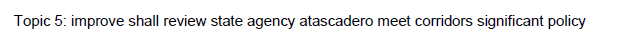



This example shows the repetitveness of keywords that suggest to reduce the number of topics

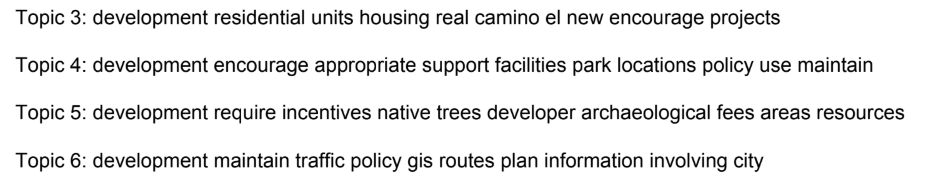

We can quickly check the topics with the code below and ensure they are up to our standards.

In [ ]:
print(topic_descriptions)

# The following code is for analysis of results including metrics and how to interpret the LDA output

The code below will plot the 16 topics and show how many policies lie within each one. We can study this distribution to see which topics we want to focus on. There is also an additional plot overlaying the policies from the scorecard to the distribution of policies.

In [ ]:
# ========== Step 1: Get the Dominant Topic for Each Important Policy ==========
# Assume 'important_policies' are stored separately
important_policies = load_csv("Atascadero Policies - atascadero_gp_policies - Sheet2.csv", text_columns1)  # Update path to your important policies CSV, the important policies are the policies in the scorecard (we realize many counties may not have a complete scorecard so this step may be skipped if that's the case)
processed_important_policies = [preprocess_text(doc) for doc in important_policies]

dominant_topics_important = []
for policy in processed_important_policies:
    transformed_policy = vectorizer.transform([policy])
    topic_distribution = lda.transform(transformed_policy)[0]
    dominant_topic = np.argmax(topic_distribution)  # Get the dominant topic
    dominant_topics_important.append(dominant_topic)

# ========== Step 2: Analyze Topic Distribution for Each Row ==========
document_topics = []
for idx, text in enumerate(processed_docs):
    transformed_doc = vectorizer.transform([text])
    topic_distribution = lda.transform(transformed_doc)[0]
    topic_probs = [f"Topic {i+1}: {prob:.3f}" for i, prob in enumerate(topic_distribution)]
    document_topics.append((f"Document {idx + 1}", topic_probs))

# ========== Step 3: Determine Dominant Topic for Each Document ==========
dominant_topics = []
for text in processed_docs:
    transformed_doc = vectorizer.transform([text])
    topic_distribution = lda.transform(transformed_doc)[0]
    dominant_topic = np.argmax(topic_distribution)
    dominant_topics.append(dominant_topic)
topic_counts = Counter(dominant_topics)

# ========== Step 4: Prepare Data for Plotting ==========
topic_labels = [f"Topic {i+1}" for i in range(num_topics)]
counts = [topic_counts[i] for i in range(num_topics)]
important_topic_counts = [dominant_topics_important.count(i) for i in range(num_topics)]

# ========== Step 5: Plot the Topic Distribution ==========
plt.figure(figsize=(12, 6))
bars_all = plt.bar(topic_labels, counts, color='skyblue', edgecolor='black', label='All Documents')
bars_important = plt.bar(topic_labels, important_topic_counts, color='red', edgecolor='black', alpha=0.6, label='Important Policies')

# ========== Step 6: Finalize and Show the Plot ==========
plt.xlabel("Topic")
plt.ylabel("Number of Documents")
plt.title("Document Distribution by Dominant Topic (with Important Policies Overlayed)")
plt.xticks(rotation=45)
for bar, count in zip(bars_all, counts):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.5, str(count), ha='center', va='bottom')

for bar, important_count in zip(bars_important, important_topic_counts):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.5, str(important_count), ha='center', va='bottom', color='white')
plt.legend()
plt.tight_layout()
plt.savefig("topic_distribution_with_important_policies_overlayed.png")
plt.show()

# Metrics

This code below shows how to calculate metrics for our results, if given ground truths. Our ground truths we used was the scorecard from Atascedero, we realize that many counties may have incomplete or no scorecard at all. In this case you can ignore this section as the metrics are only useful in determining how well our model categorized the policies.

In [ ]:
# Define the important policies based on indices (or another method)
# Link to atascedero pirs scorecard policies: https://drive.google.com/file/d/1YHJUcLogxcaPDFjlDIsbI4xtFj9s_dsn/view?usp=sharing
file_id1 = '1YHJUcLogxcaPDFjlDIsbI4xtFj9s_dsn'
csv_path1 = f'https://drive.google.com/uc?id={file_id1}'
text_columns1 = ["Policy"]
important_policies = load_csv(csv_path1, text_columns1)  # Update path to your important policies CSV (csv containing only PIRs scorecard policies)
processed_important_policies = [preprocess_text(doc) for doc in important_policies]
pirs_labels = []
for doc in processed_docs:
    match = any(doc == imp for imp in processed_important_policies)
    pirs_labels.append(1 if match else 0)

# Initialize variables to store Precision, Recall, and Specificity per topic
specificity_per_topic = []

# For each topic, calculate TP, FP, FN, TN and then compute the metrics
for topic_idx in range(num_topics):
    # Identify True Positives, False Positives, False Negatives, and True Negatives
    true_positives = sum([1 for i, count in enumerate(dominant_topics) if dominant_topics[i] == topic_idx and important_topics[i] == 1])
    false_positives = sum([1 for i, count in enumerate(dominant_topics) if dominant_topics[i] == topic_idx and important_topics[i] == 0])
    false_negatives = sum([1 for i, count in enumerate(dominant_topics) if dominant_topics[i] != topic_idx and important_topics[i] == 1])
    true_negatives = sum([1 for i, count in enumerate(dominant_topics) if dominant_topics[i] != topic_idx and important_topics[i] == 0])

    # Calculate Specificity for this topic
    if (true_negatives + false_positives) != 0:
        specificity = true_negatives / (true_negatives + false_positives)
    else:
        specificity = 0

    # Append the calculated metrics
    specificity_per_topic.append(specificity)

# Display metrics for each topic
print("\n=== Specificity per Topic ===")
for i, topic in enumerate(topic_labels):
    print(f"Topic {topic}:")
    print(f"  Specificity: {specificity_per_topic[i]:.3f}")
    print()

# Outputting the topics and their associated policies

The code below will output two pdfs: the first one has all the topic keywords and each policy with its associated probability. The second pdf has all the policies grouped under their respective topics. An image of both the pdfs is also shown below:

PDF 1: All policies with their respective probabilities


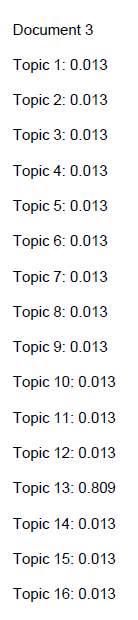

**Document 3 corresponds to the third policy in the csv**

PDF 2: All policies grouped under their respective topics

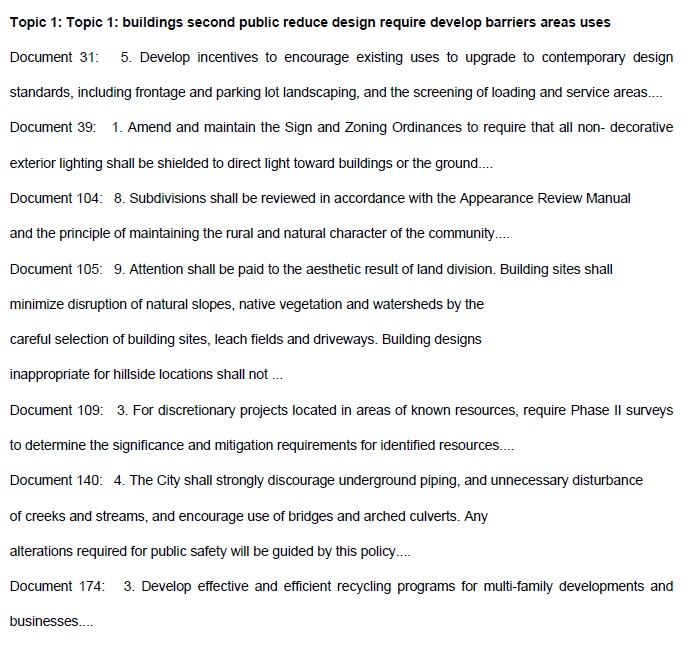

In [ ]:
def clean_text_for_pdf(text):
    replacements = {
        '\u2018': "'",  # left single quote
        '\u2019': "'",  # right single quote
        '\u201c': '"',  # left double quote
        '\u201d': '"',  # right double quote
        '\u2013': '-',  # en dash
        '\u2014': '-',  # em dash
        '\u2026': '...',  # ellipsis
        '\xa0': ' ',     # non-breaking space
    }
    for bad_char, replacement in replacements.items():
        text = text.replace(bad_char, replacement)
    return text.encode('latin-1', errors='ignore').decode('latin-1')  # Drop any remaining non-latin chars

class PDF(FPDF):
    def header(self):
        self.set_font("Arial", style='B', size=14)
        self.cell(200, 10, "Topic Modeling Results", ln=True, align='C')
        self.ln(10)

# ========== First PDF: Summary ==========
pdf_summary = PDF()
pdf_summary.set_auto_page_break(auto=True, margin=15)
pdf_summary.add_page()
pdf_summary.set_font("Arial", size=12)

# Topic descriptions
pdf_summary.cell(200, 10, "Extracted Topics:", ln=True, align='L')
pdf_summary.ln(5)
for topic in topic_descriptions:
    pdf_summary.multi_cell(0, 10, clean_text_for_pdf(topic))
pdf_summary.ln(10)

# Document topic probabilities
for doc_name, topics in document_topics:
    pdf_summary.cell(200, 10, doc_name, ln=True, align='L')
    for topic in topics:
        pdf_summary.cell(0, 10, topic, ln=True, align='L')
    pdf_summary.ln(5)

# Save summary PDF
pdf_summary.output("Topic_Modeling_Results_Atascedero.pdf")
print("Saved: Topic_Modeling_Results_Atascedero.pdf")

# ========== Second PDF: Grouped by Dominant Topic ==========
grouped_documents = defaultdict(list)
for idx, (doc, dominant_topic) in enumerate(zip(documents, dominant_topics)):
    grouped_documents[dominant_topic].append((f"Document {idx + 1}", doc[:300] + "..."))  # Truncate for readability, can change 300 to any number but these policies tend to be lengthy so it may take a while to load

pdf_grouped = PDF()
pdf_grouped.set_auto_page_break(auto=True, margin=15)
pdf_grouped.add_page()
pdf_grouped.set_font("Arial", 'B', 12)
pdf_grouped.cell(200, 10, "Documents Grouped by Dominant Topic", ln=True, align='L')
pdf_grouped.ln(5)

for topic_num in sorted(grouped_documents.keys()):
    pdf_grouped.set_font("Arial", 'B', 11)
    pdf_grouped.cell(0, 10, f"Topic {topic_num + 1}: {clean_text_for_pdf(topic_descriptions[topic_num])}", ln=True)
    pdf_grouped.set_font("Arial", size=11)
    for doc_name, doc_excerpt in grouped_documents[topic_num]:
        pdf_grouped.multi_cell(0, 10, clean_text_for_pdf(f"{doc_name}: {doc_excerpt}"))
    pdf_grouped.ln(5)

# Save grouped PDF
pdf_grouped.output("Topic_Grouped_Policies_Atascedero.pdf")
print("Saved: Topic_Grouped_Policies_Atascedero.pdf")

NOTE: The second pdf doesn't fully output all the text in the policies currently, in order to do so you need to switch the 300 into the max length of the policies (below is the code to do so). Since this is only an example I chose not to fully output the policies as it is very time consuming to output the full policy.

In [ ]:
max_len = max(len(doc) for doc in documents)
print(f"Longest document length: {max_len} characters")

# Challenges/Limitations

* Although many policies will have a high probability associated with it, there might be some with a small probability but it will be classified under a topic because we are classifying them by their highest related probability.
* The LDA output only has keywords not coherent topics, it requires either an expert to label these topics based on these keywords or have someone to prompt an LLM to create a relevant topic name.
* Some policies might not have a relevant topic, there is a case where all the topics for a given policy give the same, low probability for each topic. This is due to the small number of topics or the nature of the policy (too broad, captures a wide variety of themes).
* May require human intervention to pick the number of topics. If topics are repeating or incoherent we want to reduce the number of topics, on the other hand if topics seem to general/broad we want to increase the number of topics. For the majority of documents we have worked with, 15 is a good starting point.
